In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
# Load the dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
df = pd.read_excel(url)


In [ ]:
print('Original Data Head')
print(df.head())

Original Data Head
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [ ]:
print('Data Info')
df.info()

Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
#Check for null values
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [ ]:
# --- Data Cleaning ---

# 1. Handle Missing Values: Drop rows where CustomerID is null
df.dropna(subset=['CustomerID'], inplace=True)

# 2. Remove Cancellations: Filter out transactions with InvoiceNo starting with 'C'
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# 3. Handle Negative Quantities: Ensure Quantity is positive
df = df[df['Quantity'] > 0]

# 4. Handle Zero UnitPrice: Ensure UnitPrice is greater than zero
df = df[df['UnitPrice'] > 0]

# Convert CustomerID to integer type for consistency
df['CustomerID'] = df['CustomerID'].astype(int)

# 5. Create a 'TotalPrice' column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# --- Final Check ---
print("\nCleaned Data Info:")
df.info()

print("\nDescription of Cleaned Data:")
print(df.describe())


Cleaned Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  int64         
 7   Country      397884 non-null  object        
 8   TotalPrice   397884 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 30.4+ MB

Description of Cleaned Data:
            Quantity                    InvoiceDate      UnitPrice  \
count  397884.000000                         397884  397884.000000   
mean       12.988238  2011-07-10 23:41:23.511023360       3.116488   
min

In [ ]:
# --- RFM Calculation ---

# Set a reference date for Recency calculation (e.g., one day after the last transaction)
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Calculate RFM values for each customer
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda date: (snapshot_date - date.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

# Rename the columns for clarity
rfm.rename(columns={'InvoiceDate': 'Recency',
                    'InvoiceNo': 'Frequency',
                    'TotalPrice': 'MonetaryValue'}, inplace=True)

# Display the first 5 rows of the RFM table
print("\nRFM Data Head:")
print(rfm.head())


RFM Data Head:
            Recency  Frequency  MonetaryValue
CustomerID                                   
12346           326          1       77183.60
12347             2          7        4310.00
12348            75          4        1797.24
12349            19          1        1757.55
12350           310          1         334.40


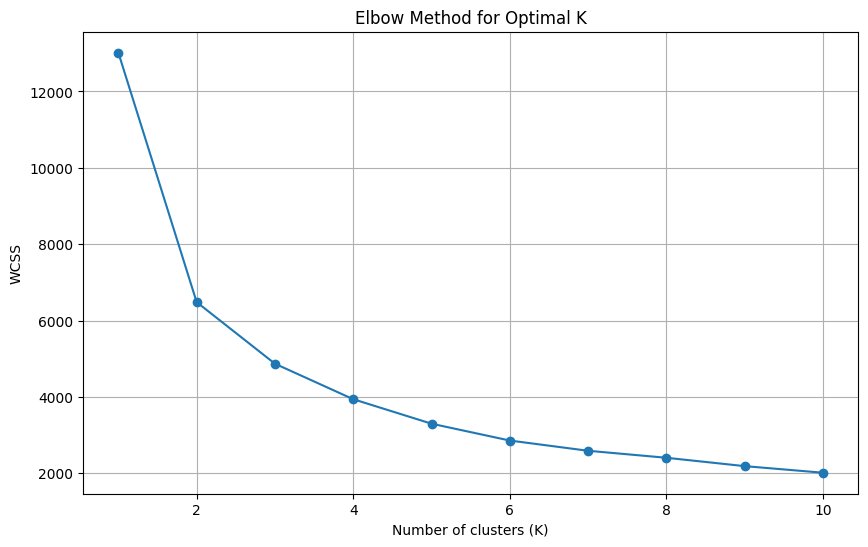


RFM Data with Cluster Labels:
            Recency  Frequency  MonetaryValue  Cluster
CustomerID                                            
12346           326          1       77183.60        2
12347             2          7        4310.00        1
12348            75          4        1797.24        2
12349            19          1        1757.55        0
12350           310          1         334.40        3


In [ ]:
# --- K-Means Clustering ---

# 1. Handle Skewness and Scale the Data
# Log transformation to handle skewed data
rfm_log = np.log1p(rfm)

# Scaling the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

# 2. Determine the Optimal Number of Clusters (K) using the Elbow Method
wcss = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled)
    wcss[k] = kmeans.inertia_

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(list(wcss.keys()), list(wcss.values()), 'o-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

# 3. Apply K-Means with the chosen K
# Let's assume the elbow is at K=4 based on the plot
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, init='k-means++', random_state=42)
kmeans.fit(rfm_scaled)

# Assign the cluster labels to the original RFM dataframe
rfm['Cluster'] = kmeans.labels_

print("\nRFM Data with Cluster Labels:")
print(rfm.head())


Cluster Analysis (Mean RFM Values):
         Recency  Frequency  MonetaryValue
Cluster                                   
0          18.12       2.15         551.82
1          12.13      13.71        8074.27
2          71.08       4.08        1802.83
3         182.50       1.32         343.45


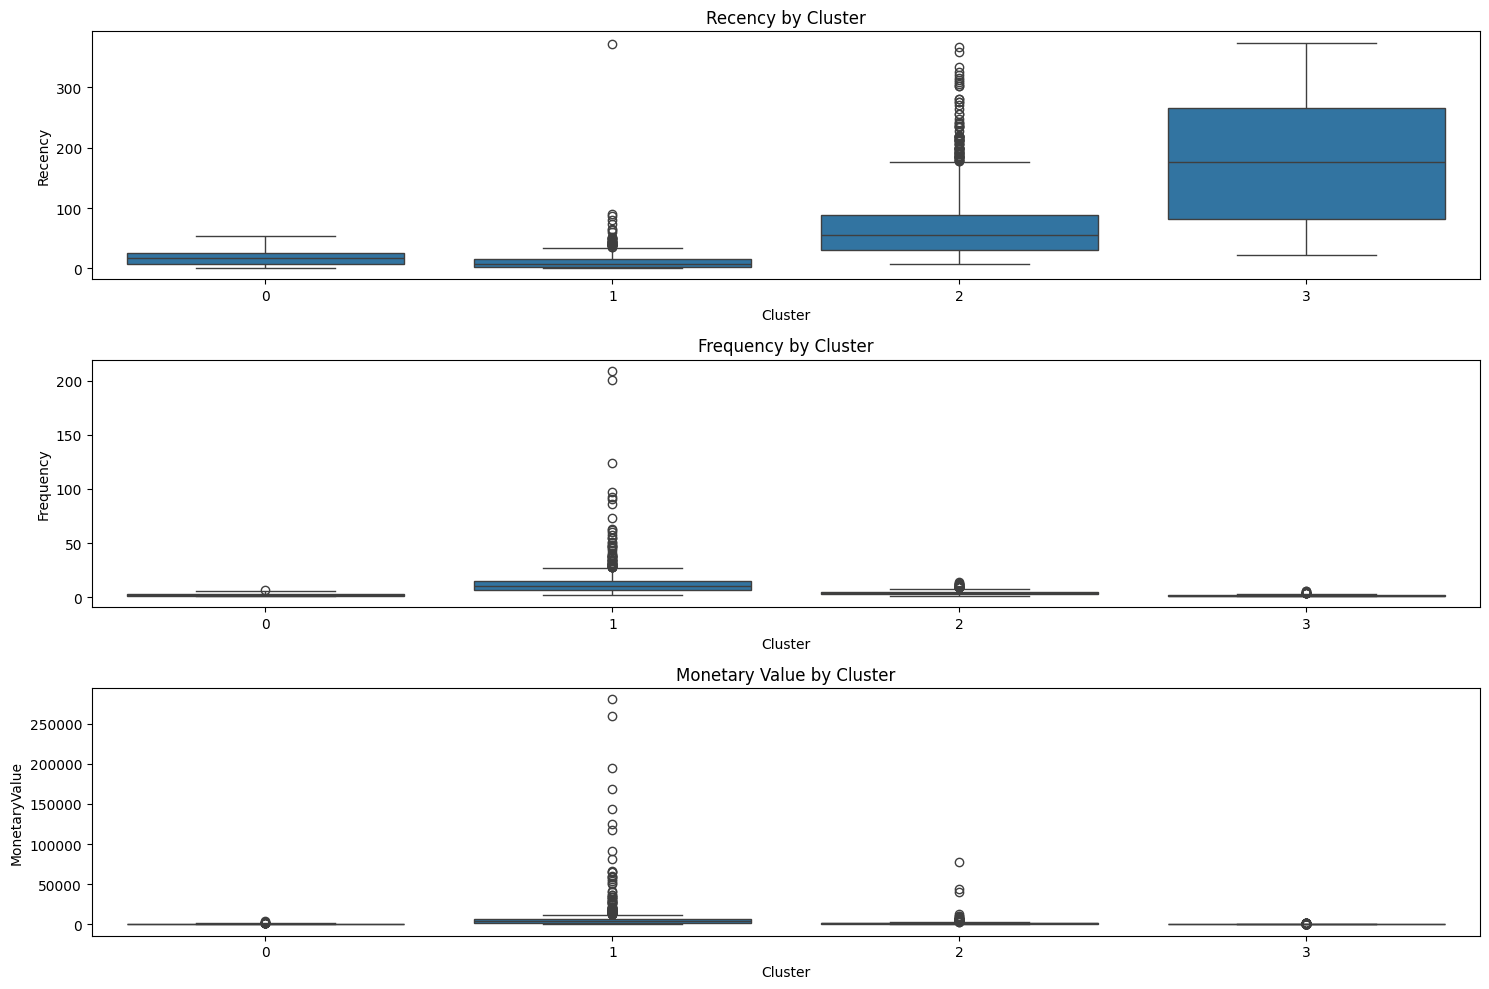

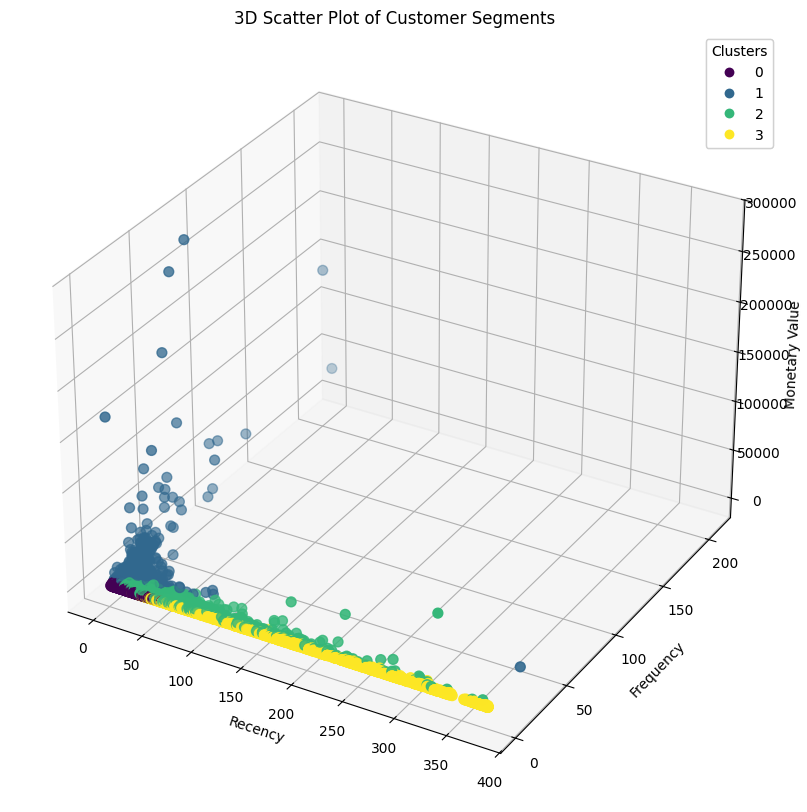

In [ ]:
# --- Segment Analysis and Visualization ---

# 1. Analyze the average RFM values for each cluster
cluster_analysis = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean'
}).round(2)

print("\nCluster Analysis (Mean RFM Values):")
print(cluster_analysis)

# 2. Visualize the segments
# Boxplots for each RFM feature by cluster
plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1)
sns.boxplot(x='Cluster', y='Recency', data=rfm)
plt.title('Recency by Cluster')

plt.subplot(3, 1, 2)
sns.boxplot(x='Cluster', y='Frequency', data=rfm)
plt.title('Frequency by Cluster')

plt.subplot(3, 1, 3)
sns.boxplot(x='Cluster', y='MonetaryValue', data=rfm)
plt.title('Monetary Value by Cluster')

plt.tight_layout()
plt.show()

# 3D Scatter Plot for visualization
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['MonetaryValue'], c=rfm['Cluster'], s=50, cmap='viridis')

ax.set_title('3D Scatter Plot of Customer Segments')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary Value')

# Create a legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()

In [ ]:
# --- Final Model Evaluation with Silhouette Score ---
from sklearn.metrics import silhouette_score

# The score is calculated using the scaled data and the predicted cluster labels
# rfm_scaled was created in the previous cell
silhouette_avg = silhouette_score(rfm_scaled, rfm['Cluster'])

print(f"Average Silhouette Score for the final model (K={k_optimal}): {silhouette_avg:.4f}")

Average Silhouette Score for the final model (K=4): 0.3371
